In [11]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
%matplotlib inline

Stuff to figure out:
- Does the blackjack class terminate an episode when a player either reaches 21 or goes bust? I don't think so. 
- Make it terminate when going bust/ reaching 21
- Incorporate gym.Env functionality for stepping the environment, resetting it, rendering, etc.
- Plot state-value function learned in order to determine if it matches with the function found by the book and by Denny Britz

In [3]:
class blackjack_game(gym.Env):
    def __init__(self, dealer_decision_point):
        self.dealer_decision_point = dealer_decision_point
        #self.cards = ['Ace', 2, 3, 4, 5, 6, 7, 8, 9, 10, 'face']
        self.cards = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10])
        
    def drawtwocards(self):
        rand_cards = np.random.randint(0, len(self.cards), size=2)
        return rand_cards
    
    def drawonecard(self):
        rand_card = np.random.randint(0, len(self.cards))
        return rand_card
    
    def computepoints(self, rand_cards):
        points = 0
        hand = self.cards[rand_cards]
        if np.isin(1, hand):
            if np.sum(hand) + 10 <= 21:
                points = np.sum(hand) + 10
        else:
            points = np.sum(hand)
            
        return points
    
    def dealerplay(self, point_total):
        # 1 is hit, 0 is stick
        if point_total < self.dealer_decision_point:
            return 1
        elif point_total >= self.dealer_decision_point:
            return 0
        
    def agent_obs(self, agent_cards, dealer_cards):
        #a_cards = [self.cards[i] for i in agent_cards]
        #d_card = self.cards[dealer_cards[0]]
        a_points = self.computepoints(agent_cards)
        d_points = self.computepoints(dealer_cards)
        agent_ace_usable = int(a_points <= 10)
        return a_points, d_points, agent_ace_usable
    
    def check_win(self, agent_cards, dealer_cards, both_done_playing):
        agent_points = self.computepoints(agent_cards)
        dealer_points = self.computepoints(dealer_cards)
        agent_win, dealer_win = 0, 0
        if agent_points == 21: agent_win += 1
        if dealer_points == 21: dealer_win += 1
        
        if agent_points > 21: return -1
        if dealer_points > 21: return 1
        
        if both_done_playing and agent_points > dealer_points:
            agent_win += 1
        if both_done_playing and dealer_points > agent_points:
            dealer_win += 1
         
        if agent_win == dealer_win: return 0
        if agent_win > dealer_win: return 1
        if agent_win < dealer_win: return -1
        
        
    def visualize(self, points, turn, action):
        if turn is 1: player = 'MC'
        elif turn is 0: player = 'dealer'
        
        print(player, 'has', points, ' points')
        print(player, 'chooses to', action)
        print()
        
    def play(self, start, policy):
        sequence = []
        a_cards, d_cards = self.cards[self.drawtwocards()], self.cards[self.drawtwocards()]
        both_done_playing = False
        count = 0
        while both_done_playing is False:
            if start == True:
                start = False
                dealer_turn = False
                a_turn = True
            
            if a_turn is True and dealer_turn is False:
                a_obs = self.agent_obs(a_cards, [d_cards[0]])
                a_action = policy(a_obs[0])
                if a_action is 1:
                    a_cards = np.append(a_cards, self.cards[self.drawonecard()])
                elif a_action is 0:
                    a_turn = False
                    dealer_turn = True
                    
            if dealer_turn is True and a_turn is False:
                d_action = self.dealerplay(self.computepoints(d_cards))
                a_obs = self.agent_obs(a_cards, d_cards)
                if d_action is 1:
                    d_cards = np.append(d_cards, self.cards[self.drawonecard()])
                elif d_action is 0:
                    both_done_playing = True
                    #self.check_win(a_cards, d_cards, both_done_playing)
                    
            if self.computepoints(a_cards) > 21 or self.computepoints(d_cards) > 21:
                both_done_playing = True
                a_obs = self.agent_obs(a_cards, d_cards)
                sequence.append(np.array([a_obs, a_action, self.check_win(a_cards, d_cards, both_done_playing)]))
                break
            sequence.append(np.array([a_obs, a_action, self.check_win(a_cards, d_cards, both_done_playing)]))
            count += 1
        return sequence

In [4]:
game = blackjack_game(17)
a_cards, d_cards = game.drawtwocards(), game.drawtwocards()
game.check_win(a_cards, d_cards, True)

1

In [5]:
game.computepoints(game.drawtwocards())

20

In [19]:
class monte_carlo:
    def __init__(self, num_states, environment, gamma):
        self.num_states = num_states
        self.env = environment(17)
        self.gamma = gamma
    
    def first_visit_MC_prediction(self, policy, epochs):
        V_ = np.random.rand(self.num_states)
        returns = []
        
        for ep in range(epochs):
            seq = self.env.play(True, policy=policy)
            G = 0
            for i in range(1, len(seq)):
                G = 
                if np.isin(seq[:-1], seq[i-1]) is False:
                    returns[i] += G
                    V_[i] = np.average(returns[i])
        return V_

In [20]:
num_states = 200
policy = lambda points: 1 - int(points >= 20)
policy(19)

1

In [21]:
mc = monte_carlo(200, blackjack_game, 1)

In [22]:
val_func = mc.first_visit_MC_prediction(policy, 50000)

(10, 20) (10, 20)
(20, 10)


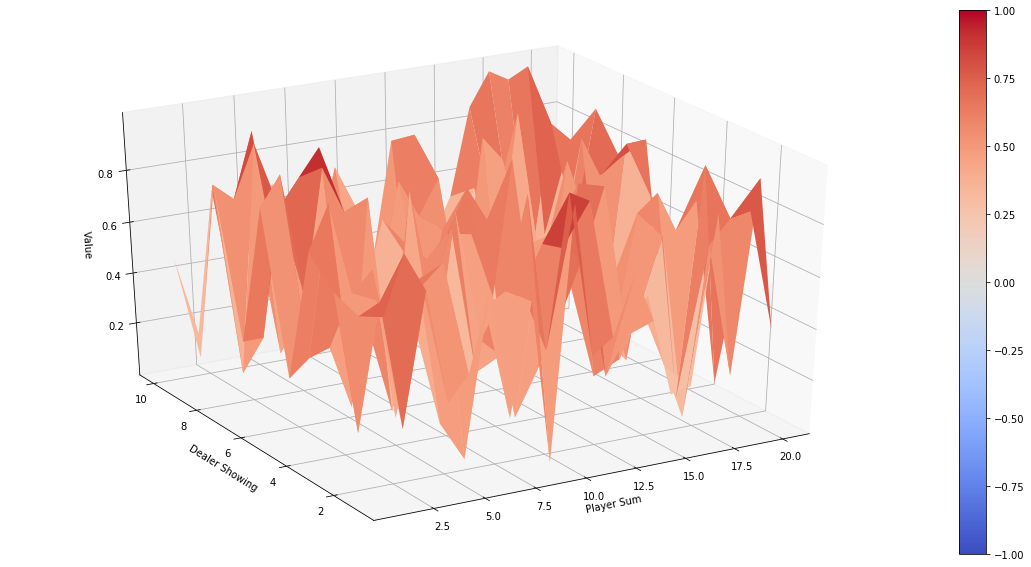

In [23]:
x = np.arange(1, 21)
y = np.arange(1, 11)
X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape)
Z = val_func.reshape(len(x), len(y))
print(Z.shape)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X.T, Y.T, Z, rstride=1, cstride=1,
    cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
ax.set_xlabel('Player Sum')
ax.set_ylabel('Dealer Showing')
ax.set_zlabel('Value')
ax.view_init(ax.elev, -120)
fig.colorbar(surf)
plt.show()

In [12]:
a = defaultdict(float)

In [13]:
a

defaultdict(float, {})